Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

🎯 XGBoost Classifier Results
Accuracy: 0.7616953218712516
Macro F1: 0.2054814021800804
Weighted F1: 0.7348608079645143

Classification Report:
               precision    recall  f1-score   support

           0      0.794     0.915     0.850      1293
           1      0.719     0.700     0.709      1020
           2      0.364     0.036     0.066       110
           3      0.600     0.054     0.098        56
           4      1.000     0.067     0.125        15
           5      0.000     0.

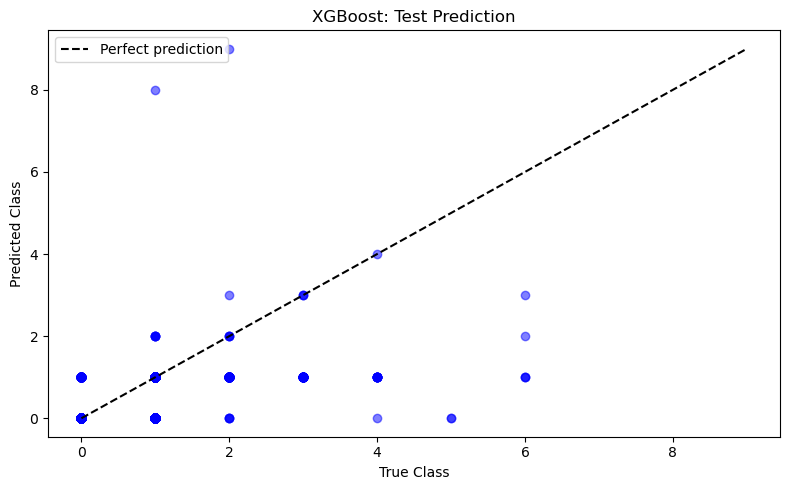


Predictions for new data: [9 9 9]

Hand 1: Predicted class 9, top-3 confidences:
   Rank 9: 0.655
   Rank 1: 0.168
   Rank 0: 0.135

Hand 2: Predicted class 9, top-3 confidences:
   Rank 9: 0.607
   Rank 0: 0.273
   Rank 1: 0.115

Hand 3: Predicted class 9, top-3 confidences:
   Rank 9: 0.497
   Rank 0: 0.302
   Rank 1: 0.154


In [1]:
# ============================================================
# Poker Hand XGBoost Classifier (balanced, improved F1)
# ============================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score

# !################################
# Data Loading
# !################################
cols = ['S1','R1','S2','R2','S3','R3','S4','R4','S5','R5','ORD']
poker_df = pd.read_csv('poker-hand-training-true.data', skiprows=1, header=None, names=cols)

# !################################
# Train / Test Split
# !################################
X = poker_df[['S1','R1','S2','R2','S3','R3','S4','R4','S5','R5']]
y = poker_df['ORD']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.11, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# !################################
# Train XGBoost Model (auto handles imbalance)
# !################################
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='multi:softmax',
    num_class=10,
    eval_metric='mlogloss',
    tree_method='hist',   # fast CPU/GPU
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# !################################
# Evaluation
# !################################
y_pred = xgb_model.predict(X_test_scaled)

print("\n🎯 XGBoost Classifier Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Weighted F1:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# !################################
# Scatter Plot (same format as before)
# !################################
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([0,9],[0,9],'k--',label='Perfect prediction')
plt.title("XGBoost: Test Prediction")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.legend()
plt.tight_layout()
plt.show()

# !################################
# Predict on sample 5-card hands (same as your test)
# !################################
new_data = pd.DataFrame({
    'S1': [1, 2, 4],
    'R1': [10, 11, 1],
    'S2': [1, 2, 4],
    'R2': [11, 13, 13],
    'S3': [1, 2, 4],
    'R3': [13, 10, 12],
    'S4': [1, 2, 4],
    'R4': [12, 12, 11],
    'S5': [1, 2, 4],
    'R5': [1, 1, 10]
})

new_scaled = scaler.transform(new_data)
new_pred = xgb_model.predict(new_scaled)
new_prob = xgb_model.predict_proba(new_scaled)

print("\nPredictions for new data:", new_pred)
for i, (pred, probs) in enumerate(zip(new_pred, new_prob)):
    top3 = sorted(list(zip(range(len(probs)), probs)), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nHand {i+1}: Predicted class {pred}, top-3 confidences:")
    for cls, pr in top3:
        print(f"   Rank {cls}: {pr:.3f}")


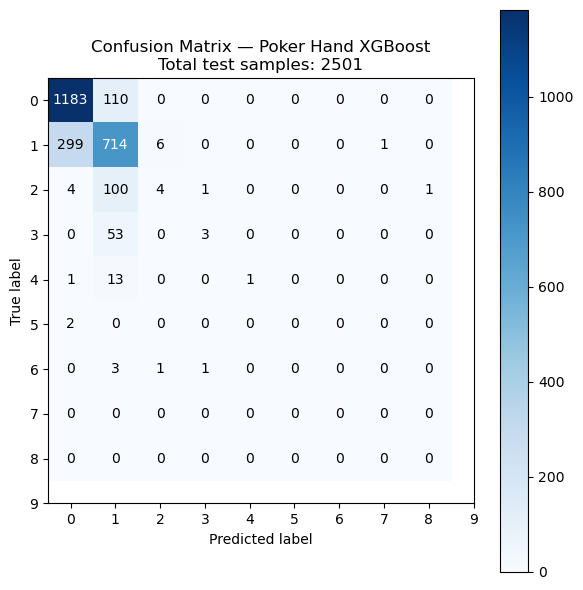

In [3]:
# ============================================================
# Confusion Matrix (same style as your KNN plot)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix — Poker Hand XGBoost\nTotal test samples: {}".format(len(y_test)))
plt.colorbar()

tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Print values inside the matrix
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
